# Exploratory Data Analysis

이번 대회의 Sentence-Level Relation Extration Task의 KLUE 데이터셋을 살펴보자. Train 데이터는 32470개, test 데이터는 7765개이며 dev 데이터셋은 따로 주어지지 않았다.

각 데이터에는 총 5가지의 properties가 있다:

1. Sentence(문장)
2. Subject Entity(주어) 
3. Object Entity(목적어)
4. Relation Label (관계 라벨)
5. Source(출처).

우리가 해결하고 싶은 task는 sentence와 subject, object entity pair $(e_{subj},e_{obj})$ 가 주어졌을 때 relation label를 예측하는 것이다.

Relation label은 총 30가지이며 18 person-related relations(인간관계), 11 organization-related relations(조직관계), and no_relation(무관계)로 나눠진다.

자세한 설명은 아래 KLUE 논문에서 가지고 온 테이블에서 확인 가능하다.

![](assets/table10.png)

"We evaluate a model using micro F1 score, computed after
excluding no_relation, and area under the precision-recall curve including all 30 classes."

Reference:
https://arxiv.org/pdf/2105.09680.pdf


In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re

import seaborn as sns
from transformers import AutoModel, AutoTokenizer


model = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model)

TRAIN_PATH = '../dataset/train/train.csv'
TEST_PATH = '../dataset/test/test_data.csv'

In [2]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

## 전처리

- `subject_entity`, `object_entity`가 `str type`으로 되어있어서 데이터를 가져오기가 힘들다.
- 우리가 편하게 불러올 수 있는 형식으로 바꾼다
- `json.loads`를 이용해 `dict type`으로 바꾸는 방법도 고려했지만 "`"`" 기호가 때문에 문제가 많이 발생해서 **regular expression**을 이용해 데이터를 가지고 오는 방법을 사용했다


In [3]:
train.subject_entity.head(3)

0    {'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...
1    {'word': '민주평화당', 'start_idx': 19, 'end_idx': ...
2    {'word': '광주FC', 'start_idx': 21, 'end_idx': 2...
Name: subject_entity, dtype: object

In [4]:
train.subject_entity = train.subject_entity.apply(lambda x : re.split("{'word': '|', 'start_idx': |, 'end_idx': |, 'type': '|'}",x.replace("\"","'"))[1:-1])
train.object_entity = train.object_entity.apply(lambda x : re.split("{'word': '|', 'start_idx': |, 'end_idx': |, 'type': '|'}",x.replace("\"","'"))[1:-1])
train.subject_entity.head(3)

0      [비틀즈, 24, 26, ORG]
1    [민주평화당, 19, 23, ORG]
2     [광주FC, 21, 24, ORG]
Name: subject_entity, dtype: object

## Check for missing values

아래에 보다사피 Null values들은 없다.

In [5]:
print('train data')
print(train.isnull().sum())
print('-' * 50)
print('test data')
print(test.isnull().sum())

train data
id                0
sentence          0
subject_entity    0
object_entity     0
label             0
source            0
dtype: int64
--------------------------------------------------
test data
id                0
sentence          0
subject_entity    0
object_entity     0
label             0
source            0
dtype: int64


## Sentence Analysis

데이터는 총 32470개인데 unique sentences는 28803개 인 것을 확인할 수 있다. 이 사실을 통해 여러 entity pair가 존재한 문장들도 학습 데이터로 포함이 되었다고 볼 수 있다. 정확히는 3번 중복되는 sentences는 244개, 2번 중복되는 sentences는 3179개, 그리고 한번만 등장하는 문장은 25380개 이다.
띄어쓰기를 포함한 평균 문장 길이는 97이며 최대 길이가 455이다.


In [6]:
train_sentence_length = train.sentence.apply(len)
train.insert(2, "sentence_length", train_sentence_length)
train_sentence_length.describe()

count    32470.000000
mean        97.083954
std         47.939902
min         14.000000
25%         64.000000
50%         87.000000
75%        118.000000
max        455.000000
Name: sentence, dtype: float64

In [7]:
train.sentence.nunique()

28803

In [8]:
sentence_count = train.sentence.value_counts()
sentence_count.unique()

array([3, 2, 1])

In [9]:
pd.DataFrame(sentence_count).pivot_table(columns=['sentence'], aggfunc='size')

sentence
1    25380
2     3179
3      244
dtype: int64

Text(0.5, 1.0, 'Sentence Length Histogram')

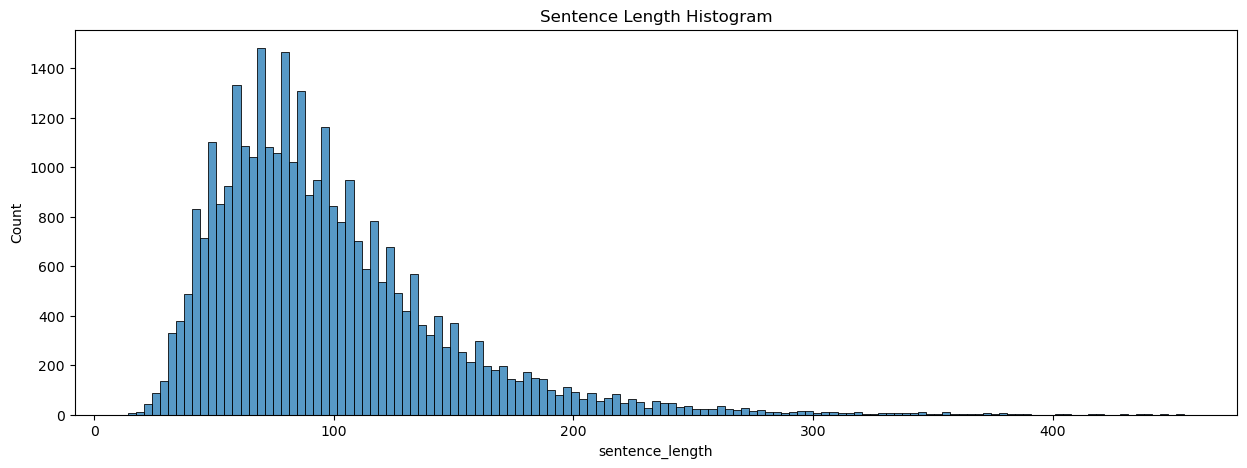

In [10]:
fig = plt.subplots(1,1, figsize=(15, 5))
sns.histplot(data=train, x="sentence_length")
plt.title("Sentence Length Histogram")

Text(0.5, 1.0, 'Sentence Length distribution per label')

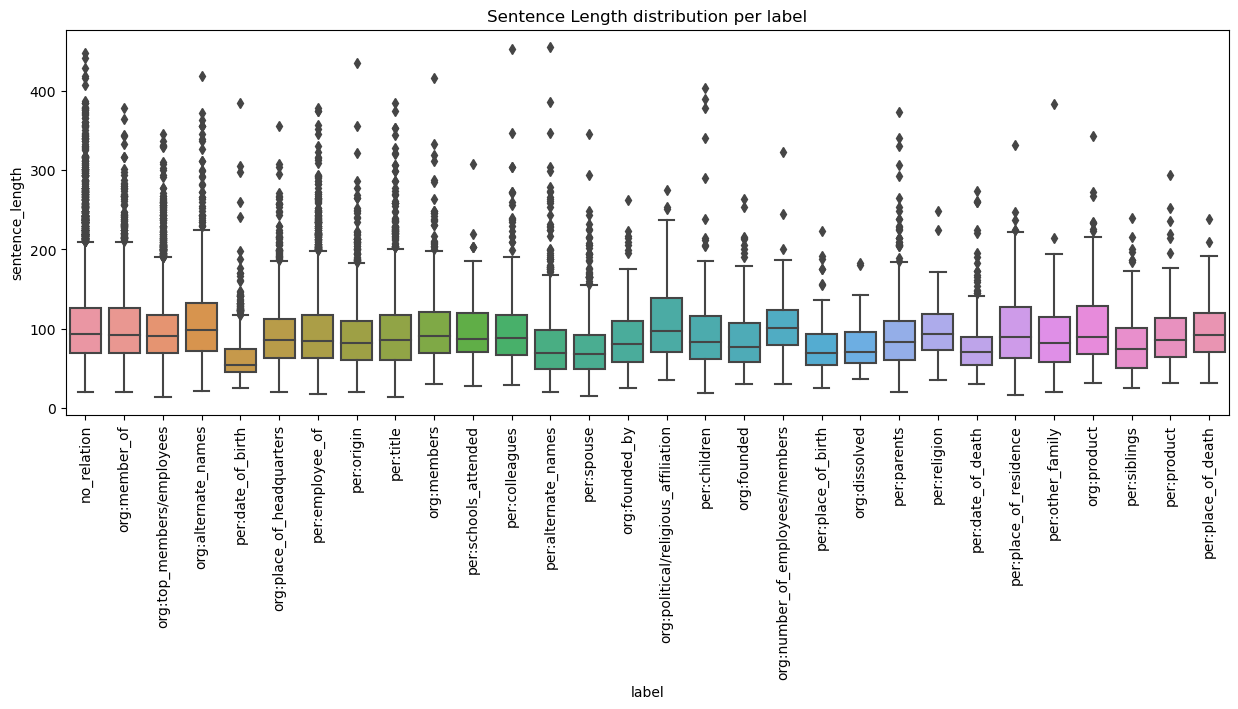

In [11]:
fig, ax = plt.subplots(1,1, figsize=(15, 5))
sns.boxplot(data=train, x='label', y='sentence_length')
plt.xticks(rotation=90)
plt.title("Sentence Length distribution per label")

## Token Analysis

- 최대 토큰 길이는 229인 것으로 확인되었다.
- [UNK] 토큰이 포함된 문장의 개수는 32470 문장 중 3218개이다.
- 한 문장에 여러 [UNK] 토큰이 등장하는 걸 고려했을 때 [UNK]의 총 개수는 6313개이다.

In [12]:
train_token = train.sentence.apply(tokenizer.tokenize)
train_token_length = train_token.apply(len)
train_token_length.describe()

count    32470.000000
mean        50.958608
std         24.921942
min          7.000000
25%         34.000000
50%         46.000000
75%         62.000000
max        229.000000
Name: sentence, dtype: float64

In [13]:
df_train_token=pd.DataFrame(data=train_token, columns = ['sentence'])
df_train_token.insert(1, "token_length", train_token_length)
df_train_token.rename(columns = {'sentence':'token'}, inplace=True)
count = 0
for i in range(len(train)):
    if '[UNK]' in df_train_token.token[i]:
        count += 1
print(f'number of sentences containing [UNK]: {count} out of {len(train)}')

number of sentences containing [UNK]: 3218 out of 32470


In [14]:
all_token_list = []
for i in range(len(train)):
    all_token_list += train_token[i]
    
token_count = Counter(all_token_list)
token_count.most_common()

[(',', 37642),
 ('.', 36210),
 ('##의', 34920),
 ('##다', 29480),
 ('##을', 29307),
 ('##에', 25994),
 ('##는', 24825),
 ('##년', 20918),
 ('(', 19211),
 (')', 19190),
 ('##이', 18360),
 ('##를', 16525),
 ('##은', 13806),
 ('##일', 13506),
 ('##하', 13031),
 ('##로', 12635),
 ('##에서', 12159),
 ('##가', 11753),
 ('##월', 11192),
 ('##고', 11073),
 ('##으로', 10444),
 ('##했', 10382),
 ('##한', 9807),
 ('##과', 8458),
 ('##었', 7760),
 ('##인', 7708),
 ('##와', 7331),
 ('##였', 6952),
 ('있', 6766),
 ('[UNK]', 6313),
 ("'", 6148),
 ('"', 5408),
 ('##대', 5170),
 ('1', 4967),
 ('##게', 4951),
 ('##지', 4908),
 ('##되', 4872),
 ('등', 4848),
 ('##도', 4719),
 ('##당', 4694),
 ('2', 4516),
 ('##이다', 4484),
 ('##자', 4369),
 ('##기', 4101),
 ('이', 4065),
 ('##들', 3933),
 ('##하고', 3856),
 ('3', 3732),
 ('##스', 3603),
 ('##시', 3564),
 ('##장', 3458),
 ('##어', 3422),
 ('그', 3403),
 ('##해', 3359),
 ('##세', 3331),
 ('##며', 3316),
 ('는', 3262),
 ('##던', 3222),
 ('~', 3159),
 ('4', 3025),
 ('-', 3025),
 ('##원', 2979),
 ('##서', 2975)

## Subject, Object Entity Analysis

Entity type으로는...

1. PER(사람)
2. ORG(조직)
3. DAT(시간)
4. LOC(장소)
5. POH(기타 표현)
6. NOH(기타 수량 표현)

총 6가지가 존재하며 이 중 subject entity는 `PER`과 `ORG` type 밖에 없고 object entity는 모든 6가지 type이 존재한다.

질문: 왜 그럴까? 답은 회의 때 (NER?)

In [15]:
train_subject_word = train.subject_entity.apply(lambda x : x[0]).value_counts()
train_subject_word.head(10)

민주당       144
화순군       107
고흥군        99
광주광역시      92
더불어민주당     92
여수시        82
목포시        80
문재인        80
영암군        75
포천시        73
Name: subject_entity, dtype: int64

In [16]:
train_object_word = train.object_entity.apply(lambda x : x[0]).value_counts()
train_object_word.head(10)

대한민국      276
자유한국당     268
더불어민주당    236
문재인       135
UEFA      117
캐나다       115
김대중       113
스페인       113
정의당       111
골키퍼       110
Name: object_entity, dtype: int64

In [17]:
train_subject_type = train.subject_entity.apply(lambda x : x[3]).value_counts()
train_subject_type.head(10)

PER    16786
ORG    15684
Name: subject_entity, dtype: int64

In [18]:
train_object_type = train.object_entity.apply(lambda x : x[3]).value_counts()
train_object_type.head(10)

PER    9788
ORG    9346
POH    5113
DAT    4249
LOC    3561
NOH     413
Name: object_entity, dtype: int64

## Label Analysis

no relation이 많은 이유는 KLUE 논문에서 나와있다.
- Irrelevant pairs will account for a large portion of realistic relation distribution between two arbitrary
entities. Therefore, this approach helps to set up real-world scenario.

즉 현실을 바탕으로 데이터셋을 만들었는데 현실에서는 무관계인 객체 쌍들이 많이 존재할 거라서 그랬다고 한다.


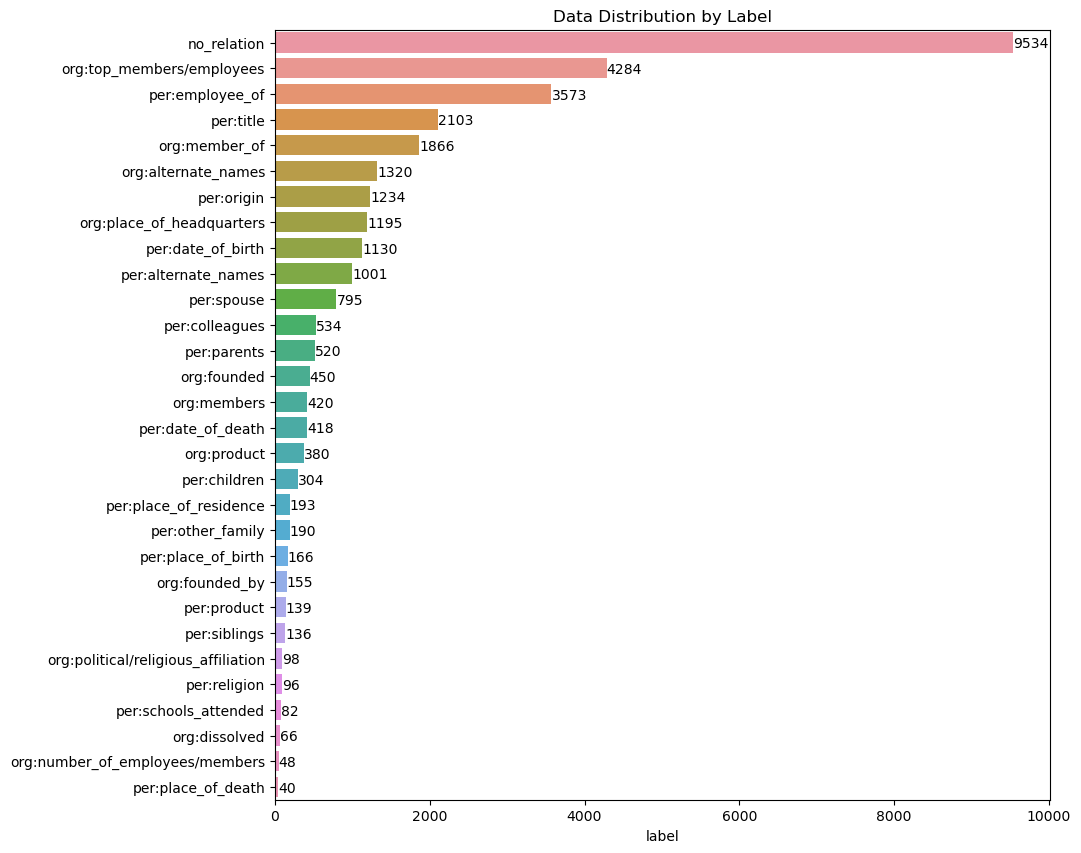

In [19]:
train_label = train.label.value_counts()
df_train_label = pd.DataFrame(train_label)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
sns.barplot(y=df_train_label.index, x=df_train_label.label).set(title="Data Distribution by Label")

for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_width()), (p.get_x() + p.get_width(), p.get_y()+0.6), fontsize=10)

plt.show()

## Source

wikitree는 https://www.wikitree.co.kr/

wikipedia는 https://ko.wikipedia.org/

policy_briefing은 https://www.korea.kr/main.do

training set:
wikipedia: 21620개(66.5%)

wikitree: 10672개(32.9%)

policy_briefing: 178개(0.5%)

### train vs test:

wikipedia: 66.5% vs 52.6%

wikitree: 32.9% vs 46.6%

policy_briefing: 0.5% vs 0.7%

In [20]:
print('train data')
print(train['source'].value_counts())
print('-' * 50)
print('test data')
print(test['source'].value_counts())
print('train data')
print('-' * 50)
print('-' * 50)
print(train['source'].value_counts(normalize=True))
print('-' * 50)
print('test data')
print(test['source'].value_counts(normalize=True))

train data
wikipedia          21620
wikitree           10672
policy_briefing      178
Name: source, dtype: int64
--------------------------------------------------
test data
wikitree           4088
wikipedia          3621
policy_briefing      56
Name: source, dtype: int64
train data
--------------------------------------------------
--------------------------------------------------
wikipedia          0.665845
wikitree           0.328673
policy_briefing    0.005482
Name: source, dtype: float64
--------------------------------------------------
test data
wikitree           0.526465
wikipedia          0.466323
policy_briefing    0.007212
Name: source, dtype: float64
